In [2]:
# Import library
import pandas as pd
import numpy as np
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import seaborn as sns
import json

### **Dataset Components**
1. **Transaction Data (transactions_data.csv)**
* Detailed transaction records including amounts, timestamps, and merchant details
* Covers transactions throughout the 2010s
* Features transaction types, amounts, and merchant information
* Perfect for analyzing spending patterns and building fraud detection models
2. **Card Information (cards_dat.csv)**
* Credit and debit card details
* Includes card limits, types, and activation dates
* Links to customer accounts via card_id
* Essential for understanding customer financial profiles
3. **Merchant Category Codes (mcc_codes.json)**
* Standard classification codes for business types
* Enables transaction categorization and spending analysis
* Industry-standard MCC codes with descriptions
4. **Fraud Labels (train_fraud_labels.json)**
* Binary classification labels for transactions
* Indicates fraudulent vs. legitimate transactions
* Ideal for training supervised fraud detection models
5. **User Data (users_data)**
* Demographic information about customers
* Account-related details
* Enables customer segmentation and personalized analysis

## **Load data**

In [3]:
# Load csv dataset
cards_df = pd.read_csv('../../data/cards_data.csv')
txn_df = pd.read_csv('../../data/transactions_data.csv')
user_df = pd.read_csv('../../data/users_data.csv')

# Load json dataset
with open("../../data/mcc_codes.json", encoding='utf8') as  json_file:
    mcc_codes = json.load(json_file)

with open("../../data/train_fraud_labels.json", encoding='utf8') as  json_file:
    fraud_labels = json.load(json_file)


## **Data Cleaning and Transform**

### Cards Data

In [4]:
print(cards_df.shape)

(6146, 13)


#### 📊 Dataset Description:

The `cards_dataset` contains information about payment cards issued to clients, including card attributes, issuance history, credit limits, and security-related indicators. This dataset can be used to analyze customer payment behavior, credit risk, fraud detection, and card lifecycle management.

---

## 🧱 Schema & Column Description

| Column Name | Data Type | Description |
|-------------|-----------|-------------|
| **id** | Integer | Unique identifier for each card record. |
| **client_id** | Integer | Unique identifier of the client who owns the card. |
| **card_brand** | Categorical (String) | Card network provider (e.g., Visa, Mastercard). |
| **card_type** | Categorical (String) | Type of card issued (e.g., Debit, Credit, Prepaid). |
| **card_number** | String | Masked or anonymized card number identifier. Used only for record uniqueness, not real card data. |
| **expires** | String / Date | Card expiration date in MM/YYYY format. |
| **cvv** | Integer | Card verification value (security code). Typically anonymized or synthetic for privacy. |
| **has_chip** | Boolean / Categorical | Indicates whether the card has an EMV chip (`YES` / `NO`). |
| **num_cards_issued** | Integer | Number of cards issued to the client (including replacements and duplicates). |
| **credit_limit** | Numeric (Currency) | Maximum credit limit assigned to the card account. |
| **acct_open_date** | Date | Date when the card account was first opened. |
| **year_pin_last_changed** | Integer (Year) | The most recent year the card PIN was changed, used to evaluate security hygiene. |
| **card_on_dark_web** | Boolean / Categorical | Indicates whether the card information has been detected on dark web marketplaces (Yes/No). Useful for fraud risk analysis. |



In [5]:
cards_df['credit_limit'] = cards_df['credit_limit'].str.replace("$","").astype(float)
cards_df['credit_limit']

0       24295.0
1       21968.0
2       46414.0
3       12400.0
4          28.0
         ...   
6141     6900.0
6142     5700.0
6143     9200.0
6144    28074.0
6145    14400.0
Name: credit_limit, Length: 6146, dtype: float64

In [6]:
cards_df.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,24295.0,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,21968.0,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,46414.0,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,12400.0,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,28.0,09/2008,2009,No


In [7]:
cards_df.describe(include = 'all')

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
count,6146.000000,6146.000000,6146,6146,6.146000e+03,6146,6146.000000,6146,6146.000000,6146.000000,6146,6146.000000,6146
unique,NaN,NaN,4,3,NaN,259,NaN,2,NaN,NaN,303,NaN,1
top,NaN,NaN,Mastercard,Debit,NaN,02/2020,NaN,YES,NaN,NaN,02/2020,NaN,No
freq,NaN,NaN,3209,3511,NaN,377,NaN,5500,NaN,NaN,607,NaN,6146
mean,3072.500000,994.939636,NaN,NaN,4.820426e+15,NaN,506.220794,NaN,1.503091,14347.493980,NaN,2013.436707,NaN
std,1774.341709,578.614626,NaN,NaN,1.328582e+15,NaN,289.431123,NaN,0.519191,12014.463884,NaN,4.270699,NaN
min,0.000000,0.000000,NaN,NaN,3.001055e+14,NaN,0.000000,NaN,1.000000,0.000000,NaN,2002.000000,NaN
25%,1536.250000,492.250000,NaN,NaN,4.486365e+15,NaN,257.000000,NaN,1.000000,7042.750000,NaN,2010.000000,NaN
50%,3072.500000,992.000000,NaN,NaN,5.108957e+15,NaN,516.500000,NaN,1.000000,12592.500000,NaN,2013.000000,NaN
75%,4608.750000,1495.000000,NaN,NaN,5.585237e+15,NaN,756.000000,NaN,2.000000,19156.500000,NaN,2017.000000,NaN


In [8]:
print(cards_df.isnull().sum())

id                       0
client_id                0
card_brand               0
card_type                0
card_number              0
expires                  0
cvv                      0
has_chip                 0
num_cards_issued         0
credit_limit             0
acct_open_date           0
year_pin_last_changed    0
card_on_dark_web         0
dtype: int64


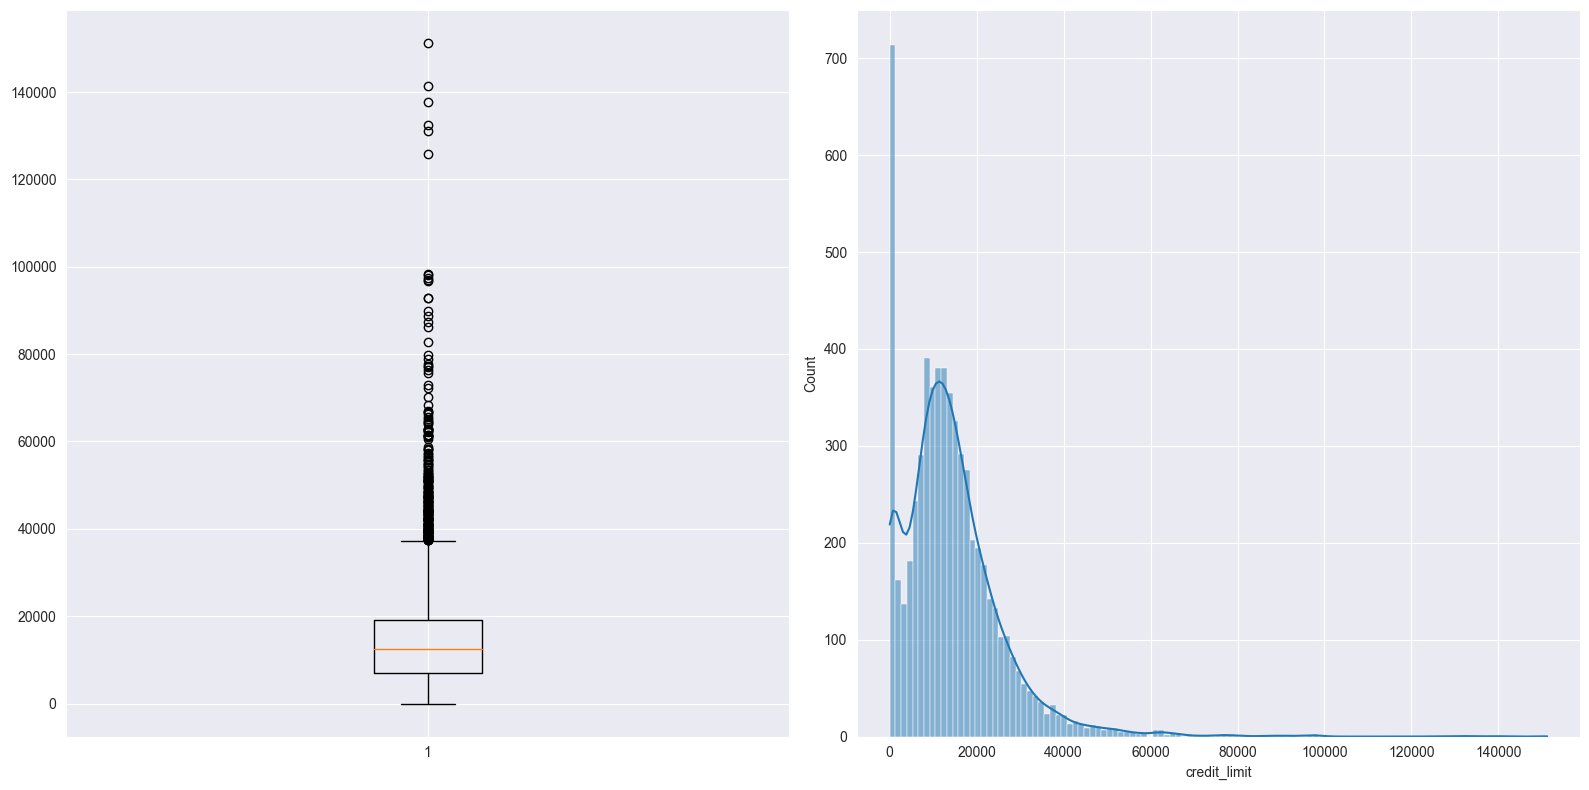

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].boxplot(cards_df['credit_limit'])

sns.histplot(cards_df['credit_limit'], kde=True, ax=axes[1])

plt.tight_layout()
plt.show()

After observing the boxplot and density distribution, we can see that:
- The credit limit distribution is right-skewed with several outliers.
- The distribution peaks around 10–15k. There is also a small peak near zero, which may be due to new customers with low credit limits. The right tail is very long, extending up to 140k, which likely represents VIP customers.

In general, the dataset reflects various customer segments. From a business
perspective, the outliers and fluctuations in credit limits are reasonable because
banks serve customers across different segments with different credit limits.
Therefore, at this stage, I will keep these outliers. These outliers will be handled
later if necessary.


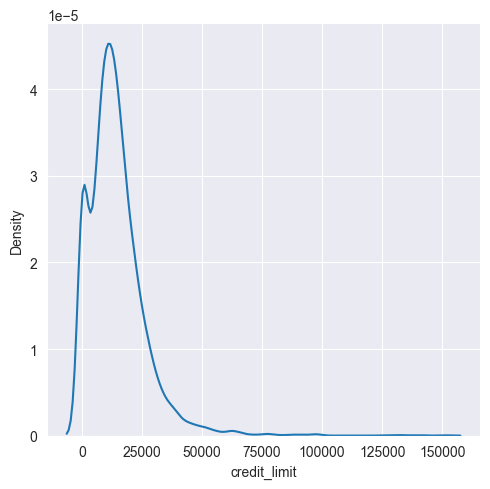

In [10]:
sns.displot(cards_df['credit_limit'], kind='kde')
plt.show()

### Transactions Data

In [11]:
txn_df.head()
print(txn_df.isnull().sum())

id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state     1563700
zip                1652706
mcc                      0
errors            13094522
dtype: int64
